In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

import numpy as np

import keras
import keras.layers as layers
import tensorflow as tf
import os
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [2]:
data = pd.read_csv("master_dataset/processed_data.csv")
# drop unwanted features


# Drop all the column , keep only class , overall_context

x = data['overall_content']
y = data['class'] 
    
# As we will be vectorizing the content and doing LSTM on it

print(x,y)

0        donald trump sends out embarrassing new year’s...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes an internet joke ...
3        trump is so obsessed he even has obama’s name ...
4        pope francis just called out donald trump duri...
                               ...                        
38653    'fully committed' nato backs new us approach a...
38654    lexisnexis withdrew two products chinese marke...
38655    minsk cultural hub becomes authorities in shad...
38656    vatican upbeat possibility pope francis visiti...
38657    indonesia buy $114 billion worth russian jets ...
Name: overall_content, Length: 38658, dtype: object 0        1
1        1
2        1
3        1
4        1
        ..
38653    0
38654    0
38655    0
38656    0
38657    0
Name: class, Length: 38658, dtype: int64


In [3]:
y.value_counts()

0    21196
1    17462
Name: class, dtype: int64

### Prepare the data

In [4]:
#first split the dataset into training and test sets


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 4222)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

#check that train set is balance
y_train.value_counts()

# Since the dataset is pretty balanced, Real - 55% and Fake - 45% of the data,
# By oversampling, we will have duplicates in the model which will overtrain out model.
# By undersampling, we might lose out on critical information.

0    12717
1    10477
Name: class, dtype: int64

In [5]:
# Find the number of maximum text 
lst = []
words = []
for item in x_train:
    lst.append(len(item.split()))

big_list = [item.split() for item in x_train]
flat_list = [item for sublist in big_list for item in sublist]
unique = list(set(flat_list))


In [6]:
print(len(unique)) # How many different words are there
print(max(lst)) # What the maximum word in an article 

207463
5130


(array([2.1596e+04, 1.4800e+03, 7.0000e+01, 2.4000e+01, 1.2000e+01,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000e+00, 5.1480e+02, 1.0276e+03, 1.5404e+03, 2.0532e+03,
        2.5660e+03, 3.0788e+03, 3.5916e+03, 4.1044e+03, 4.6172e+03,
        5.1300e+03]),
 <BarContainer object of 10 artists>)

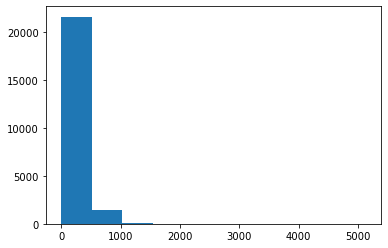

In [8]:
import matplotlib.pyplot as plt
plt.hist(lst)

In [9]:
# # Model constants.

max_features = 20000
maxlen = 1000 # Set a max length of the array, if not it will do an array of like [1,10000] , and if i would to run the LSTM, it will take 30 hours

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train.squeeze())
tokenized_train = tokenizer.texts_to_sequences(x_train.squeeze())
x_train = pad_sequences(tokenized_train , maxlen=maxlen)


In [12]:
x_train

array([[    0,     0,     0, ...,   531,   251,  1883],
       [    0,     0,     0, ...,  6672,   412,   341],
       [    0,     0,     0, ...,  7288,  7240,  3003],
       ...,
       [    0,     0,     0, ...,  6672,   412,   341],
       [    0,     0,     0, ..., 12182,  7908,   300],
       [    0,     0,     0, ...,    28,   104,  3003]])

In [13]:
tokenized_test = tokenizer.texts_to_sequences(x_validation)
x_validation = pad_sequences(tokenized_test , maxlen=maxlen)

In [14]:
x_validation

array([[   0,    0,    0, ...,  355,   25,   19],
       [   0,    0,    0, ..., 3628,  412,  341],
       [   0,    0,    0, ..., 2772,  412,  341],
       ...,
       [   0,    0,    0, ..., 3582,  412,  341],
       [   0,    0,    0, ..., 1239,   13,  392],
       [   0,    0,    0, ...,   15,    1,   93]])

In [15]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test , maxlen=maxlen)


In [16]:
x_test

array([[    0,     0,     0, ...,  8425,    85,   548],
       [    0,     0,     0, ...,  2814,  3091,  1620],
       [    0,     0,     0, ...,   172,   104,  4504],
       ...,
       [    0,     0,     0, ...,    15,     1,    93],
       [    0,     0,     0, ...,   164,  6376,   933],
       [    0,     0,     0, ...,    92, 10793,  4960]])

## Build A model

In [20]:
max_features = 20000
batch_size = 256
epochs = 10
embed_size = 100

model = keras.models.Sequential()
model.add(layers.Embedding(max_features,embed_size))
model.add(layers.Dropout(0.5))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid",name="predictions"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])


## Train and evalute the model

In [21]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

In [22]:
model.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=2)

Epoch 1/2
725/725 [==============================] - 1050s 1s/step - loss: 0.1762 - accuracy: 0.9189 - val_loss: 0.0159 - val_accuracy: 0.9953
Epoch 2/2
725/725 [==============================] - 1141s 2s/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0213 - val_accuracy: 0.9933


In [23]:
# Prediction if the news is fake 
# Class 1 (Fake) if predicted prob >= 0.5, else class 0 (Real)

y_pred = (model.predict(x_test) >= 0.5).astype("int")


242/242 [==============================] - 82s 307ms/step


In [24]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.99      1.00      0.99      3497

    accuracy                           0.99      7732
   macro avg       0.99      0.99      0.99      7732
weighted avg       0.99      0.99      0.99      7732



### Analysis after Training Model

In [26]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 ,  "%")
print("Accuracy of the model on Validation Data is - " , model.evaluate(x_validation,y_validation)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


725/725 [==============================] - 212s 293ms/step - loss: 0.0023 - accuracy: 0.9993
Accuracy of the model on Training Data is -  99.9267041683197 %
242/242 [==============================] - 62s 254ms/step - loss: 0.0213 - accuracy: 0.9933
Accuracy of the model on Validation Data is -  99.32746887207031 %
242/242 [==============================] - 63s 261ms/step - loss: 0.0145 - accuracy: 0.9944
Accuracy of the model on Testing Data is -  99.44387078285217 %
